Chapter 7<br/>
< Performance measure techniques >
===============================

<br/>

### Holdout Method (Sampling)
- 데이터를 Training과 Test와 나눠서 모델을<br/>
생성하고 테스트하는 기법
- 가장 일반적인 모델 생성을 위한 데이터 랜덤 샘플링 기법
- Training과 Test를 나누는 비율은 데이터의 크기에 따라 다름

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
X, y = np.arange(10).reshape((5, 2)), range(5)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.44,
                                                   random_state=42)

### 성능 측정을 위해 데이터를 나누는 방법
- Training : Model Building
- Validation : Model Check
- Test : Model Evaluation

### Validation Set
- Test Set은 Model이 생성시 절대 Training Set에 포함되지 않아야 함
- Test Set과 달리 Model 생성시 Model에 성능을 평가하기 위해 사용
- Hyper Parameter Turning 시 성능 평가를 위해 Overfitting 방지
- Training 중간에 Model의 성능을 점검

### K-fold cross validation
- 학습 데이터를 K번 나눠서 Test와 Train을 실시 -> Test의 평균값을 사용
- 모델의 Parameter 튜닝, 간단한 모델의 최종 성능 측정등 사용

In [4]:
from sklearn import datasets

boston = datasets.load_boston()

In [5]:
X = boston.data
y = boston.target

In [6]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(X):
    print("TRAIN - ", len(train_index))
    print("TEST - ",  len(test_index))

TRAIN -  455
TEST -  51
TRAIN -  455
TEST -  51
TRAIN -  455
TEST -  51
TRAIN -  455
TEST -  51
TRAIN -  455
TEST -  51
TRAIN -  455
TEST -  51
TRAIN -  456
TEST -  50
TRAIN -  456
TEST -  50
TRAIN -  456
TEST -  50
TRAIN -  456
TEST -  50


In [7]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=10)
lasso_regressor = Lasso()
ridge_regressor = Ridge()

lasso_mse = []
ridge_mse = []

for train_index, test_index in kf.split(X):
    lasso_regressor.fit(X[train_index], y[train_index])
    ridge_regressor.fit(X[train_index], y[train_index])
    
    lasso_mse.append(mean_squared_error(y[test_index], lasso_regressor.predict(X[test_index])))
    ridge_mse.append(mean_squared_error(y[test_index], ridge_regressor.predict(X[test_index])))

In [8]:
sum(lasso_mse) / 10, sum(ridge_mse) / 10

(34.464084588302299, 34.078246209259433)

### K-fold Cross Validation
- cross_val_score 함수로 한번에 해결 가능
- sklearn응 pipeline등을 위해 "High is better"로 처리
    + MSE를 Negative로 변환
- 이로인해 RMSE를 지원하지 않는다.

In [9]:
from sklearn.model_selection import cross_val_score
import numpy as np 

lasso_regressor = Lasso(warm_start=False)
ridge_regressor = Ridge()

lasso_scores = cross_val_score(lasso_regressor, X, y, cv=10, scoring='neg_mean_squared_error')
ridge_scores= cross_val_score(ridge_regressor, X, y, cv=10, scoring='neg_mean_squared_error')

np.mean(lasso_scores), np.mean(ridge_scores)

(-34.464084588302299, -34.078246209259433)

### Leave One Out (LOO)
- Simple cross validation
    + k = data size
- 한번에 한 개의 데이터만 Test set으로 사용한다.
    + 총 k번 iteration

In [10]:
from sklearn.model_selection import LeaveOneOut

test = [1, 2, 3, 4]
loo = LeaveOneOut()

for train, test in loo.split(test):
    print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


In [11]:
loo = LeaveOneOut()
    
lasso_scores = cross_val_score(lasso_regressor, 
                               X, y, cv=loo, 
                               scoring='neg_mean_squared_error')
ridge_scores= cross_val_score(ridge_regressor, 
                              X, y, cv=loo, 
                              scoring='neg_mean_squared_error')

np.mean(lasso_scores), np.mean(ridge_scores)

(-28.409266762049334, -23.862836317209958)

In [12]:
lasso_scores = cross_val_score(lasso_regressor,
                               X, y, cv=kf,
                               scoring='neg_mean_squared_error')
ridge_scores= cross_val_score(ridge_regressor,
                              X, y, cv=kf,
                              scoring='neg_mean_squared_error')

In [13]:
import matplotlib.pyplot as plt

labels = ["LASSO", "RIDGE"]
plt.boxplot((lasso_scores, ridge_scores), labels=labels)
plt.grid(linestyle="--")
plt.show()

### Validation set for parameter turning
- Validation set의 많은 이유중 하나가 Hyper parameter turning
- Number of iterations(SGD), Number of branch(Tree-based) etc..
- Validation set의 성능으로 최적의 parameter를 찾는다.
- Validation set 결과와 Training set 결과의 차이가 벌어지면 overfitting

In [14]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [15]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(X)
X_scaled = std.transform(X)

eta0 = 0.0001 
max_iter = 100

In [16]:
from sklearn.model_selection import train_test_split


X_train_dataset, X_test, y_train_dataset, y_test = train_test_split(X_scaled,y, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

sgd_regressor = SGDRegressor(eta0=eta0, 
                             max_iter=max_iter, 
                             warm_start=True, 
                             learning_rate="constant")

rmse_val_score = []
rmse_train_score = []
model_list = []

X_train, X_val, y_train, y_val = train_test_split(X_train_dataset,
                                                  y_train_dataset, 
                                                  test_size=0.2, 
                                                  random_state=42)
sgd_regressor.fit(X_train,y_train)


for i in range(300):
    y_pred = sgd_regressor.predict(X_train)
    y_true = y_train
    rmse_train_score.append(rmse(y_pred, y_true))

    y_pred = sgd_regressor.predict(X_val)
    y_true = y_val
    rmse_val_score.append(rmse(y_pred, y_true))
    model_list.append(sgd_regressor)

    coef = sgd_regressor.coef_.copy()
    intercept = sgd_regressor.intercept_.copy()

    sgd_regressor = SGDRegressor(eta0=eta0, 
                                 max_iter=max_iter, 
                                 warm_start=True, 
                                 learning_rate="constant")
    
    sgd_regressor.fit(X_train,y_train, 
                      coef_init=coef, 
                      intercept_init=intercept)

C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWa

C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWa

C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWa

C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWa

C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWa

C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Beginning\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWa

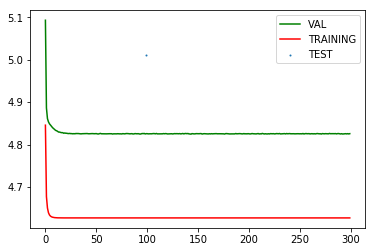

In [17]:
plt.plot(range(len(rmse_val_score)), rmse_val_score,  c="G", label="VAL")
plt.plot(range(len(rmse_train_score)), rmse_train_score,  c="r", label="TRAINING")
plt.scatter(99, rmse(y_test,sgd_regressor.predict(X_test)), s=1, label="TEST")
plt.legend()
plt.show()

In [18]:
np.argsort(rmse_val_score)

array([143,  93, 271, 154, 176,  66, 292,  52, 254, 215, 210,  86,  75,
       290, 218,  98, 160, 142, 120, 125, 220, 293, 181, 113, 298, 201,
       231, 260,  92, 236, 265, 212, 162, 296, 180, 133, 207, 217, 185,
       141, 277, 225,  87,  51, 184, 183, 198, 186,  94, 136, 263, 146,
       110, 111,  59, 286, 196, 101,  35,  83, 232, 121, 182, 194,  78,
       252, 193,  73, 147,  68, 112, 164,  70,  60, 174, 245,  27, 108,
        69, 206, 202, 278,  74, 104, 175, 115, 274, 188,  67, 269, 250,
       102,  57,  90, 294, 226,  72, 155,  56,  29, 169, 249, 289, 243,
       150, 123, 205, 200, 241, 192, 233, 238, 189,  55, 246, 211, 114,
       126,  61, 145, 131, 165,  43, 234, 247, 266,  77, 208, 117, 190,
       103, 172, 223, 214,  34, 229, 219, 171, 124, 122,  53, 242, 151,
       216, 257, 204, 222, 251,  42, 159,  65, 170, 161, 244,  89, 261,
        48, 276, 157, 273, 158,  63,  58, 128,  36, 197, 270,  71,  84,
       130, 166, 258, 248,  49, 179, 139,  64,  82, 262, 291, 14

In [19]:
rmse(y_test,sgd_regressor.predict(X_test))

5.0104769719914541

In [20]:
rmse(y_test,model_list[222].predict(X_test))

5.0099416622743602

In [21]:
model_list[0].coef_

array([-0.48417164,  0.24691856, -0.22190252,  0.88070508, -0.70062524,
        3.88721131, -0.02506808, -1.77890435,  0.12201137, -0.49085847,
       -1.78934467,  0.95636037, -3.06381234])

### Etc...
- RepatedKFold - 중복이 포함된 K-Folld 생성
- LeavePOut - 한번에 P개를 뽑음(Not LOO for one data)
- shuffleSplit - 독립적인(중복되는) 데이터 Sampling
- StratifiedKFold - Y값 비율에 따라 뽑음
- GroupKFold - 그룹별로 데이터를 Sampling